In this notebook, we try to answer the question: with an optimized discriminator, does the Rabi amplitude change with and without DRAG correction?

### References

[1]: Li, Z., Liu, P., Zhao, P. *et al.* Error per single-qubit gate below 10−4 in a superconducting qubit. *npj Quantum Inf* **9**, 111 (2023). [https://doi.org/10.1038/s41534-023-00781-x](https://doi.org/10.1038/s41534-023-00781-x).

[2]: Z. Chen *et al.* Measuring and Suppressing Quantum State Leakage in a Superconducting Qubit. *Phys. Rev. Lett.* **116**, 020501 (2016) [https://doi.org/10.1103/PhysRevLett.116.020501](https://doi.org/10.1103/PhysRevLett.116.020501). 

## Dependencies

In [1]:
%config InlineBackend.figure_formats = ['svg']

import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

In [2]:
provider = IBMProvider()
print(provider.backends())

backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
qubit_12_freq = qubit_01_freq + qubit_anharmonicty

[<IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>]


In [3]:
p12_amp = 0.2234824425369455 # 6th Dec 2023

with pulse.build(backend=backend) as hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp/2, sigma=24, beta=-0.5, name='hp12'), drive_chan)
    
hp12_gate = Gate(r'X_{\pi/2}^{(12)}', weight, [])
    
with pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp, sigma=24, beta=-0.5, name='p12'), drive_chan)

p12_gate = Gate(r'X_{\pi}^{(12)}', weight, [])

In [4]:
with pulse.build(backend=backend) as delay_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(10000, drive_chan)
    
delay_gate = Gate('Delay for 5us', weight, [])

### Discriminator circs

In [5]:
ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.append(delay_gate, [qubit])
ground_circ.measure(qubit, cbit)
ground_circ.add_calibration(delay_gate, [qubit], delay_sched)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.append(delay_gate, [qubit])
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)
first_excited_state_circ.add_calibration(delay_gate, [qubit], delay_sched)


second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.append(delay_gate, [qubit])
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(p12_gate, [qubit])
second_excited_state_circ.add_calibration(delay_gate, [qubit], delay_sched)
second_excited_state_circ.add_calibration(p12_gate, [qubit], p12_sched)

discrim_circs = qiskit.transpile([ground_circ, first_excited_state_circ, second_excited_state_circ], backend=backend)

## Amplitude w/o DRAG

In [6]:
amps = np.linspace(-1, 1, 100)

rabi_circs_wDRAG = []

rabi12_gate = Gate(r'Rabi Gate', weight, [])

for amp in amps:
    
    with pulse.build(backend=backend) as rabi12_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_12_freq, drive_chan)
        pulse.play(pulse.Drag(duration=96, amp=amp, sigma=24, beta=-0.5), drive_chan)

    rabi12_circ = QuantumCircuit(num_qubits, num_cbits)
    rabi12_circ.append(delay_gate, [qubit])
    rabi12_circ.x(qubit)
    rabi12_circ.append(rabi12_gate, [qubit])
    rabi12_circ.measure(qubit, cbit)
    rabi12_circ.add_calibration(delay_gate, [qubit], delay_sched)
    rabi12_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched)
                   
    rabi_circs_wDRAG.append(rabi12_circ)
    
rabi_circs_wDRAG = qiskit.transpile(rabi_circs_wDRAG, backend=backend)

In [7]:
package = discrim_circs + rabi_circs_wDRAG

In [30]:
ampvdrag_job = backend.run(package, meas_level=1, meas_return='single', shots=2048)

In [8]:
ampvdrag_job = provider.backend.retrieve_job('cnt51mevn4c0008a37n0')

In [9]:
ampvdrag_data = DataAnalysis(experiment=ampvdrag_job, average=False, shots=2048, qubit=0)
ampvdrag_data.retrieve_data(average=False)
ampvdrag_data.build_discrim()
ampvdrag_data.count_pop()
ampvdrag_data.error_mitiq()

In [10]:
ampvdrag_data.score_012

0.9710286458333334

In [21]:
ampvdrag_data.raw_counted

[[0.943359375, 0.0283203125, 0.0283203125],
 [0.01806640625, 0.96826171875, 0.013671875],
 [0.0, 0.0, 1.0],
 [0.0087890625, 0.01025390625, 0.98095703125],
 [0.0283203125, 0.814453125, 0.1572265625],
 [0.02685546875, 0.89697265625, 0.076171875],
 [0.0263671875, 0.900390625, 0.0732421875],
 [0.02294921875, 0.931640625, 0.04541015625],
 [0.015625, 0.9404296875, 0.0439453125],
 [0.01806640625, 0.93359375, 0.04833984375],
 [0.0205078125, 0.9296875, 0.0498046875],
 [0.0205078125, 0.892578125, 0.0869140625],
 [0.01708984375, 0.84814453125, 0.134765625],
 [0.01953125, 0.791015625, 0.189453125],
 [0.0166015625, 0.73046875, 0.2529296875],
 [0.0234375, 0.65283203125, 0.32373046875],
 [0.02734375, 0.61376953125, 0.35888671875],
 [0.0263671875, 0.55859375, 0.4150390625],
 [0.0234375, 0.50341796875, 0.47314453125],
 [0.02783203125, 0.47216796875, 0.5],
 [0.01953125, 0.45166015625, 0.52880859375],
 [0.02197265625, 0.44921875, 0.52880859375],
 [0.02685546875, 0.4775390625, 0.49560546875],
 [0.01757812

In [12]:
state0_withDRAG = ampvdrag_data.mitiq_data[int(3):int(3+100), 0]
state1_withDRAG = ampvdrag_data.mitiq_data[int(3):int(3+100), 1]
state2_withDRAG = ampvdrag_data.mitiq_data[int(3):int(3+100), 2]

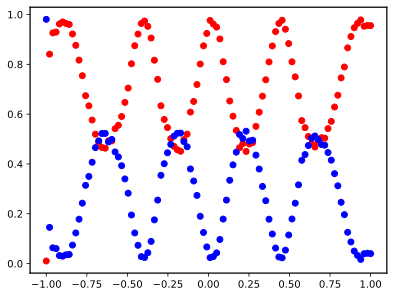

In [19]:
plt.scatter(amps, state1_withDRAG, color='red')
plt.scatter(amps, state2_withDRAG, color='blue')

In [14]:
state2_withDRAG

array([0.98057241, 0.14532929, 0.06323814, 0.060293  , 0.03209049,
       0.02975471, 0.03524781, 0.03651039, 0.07419617, 0.12292493,
       0.17814288, 0.24252907, 0.31420899, 0.34979777, 0.40676267,
       0.46562036, 0.49276821, 0.52212469, 0.52253554, 0.48838986,
       0.49837599, 0.44823937, 0.4281202 , 0.39292758, 0.33991866,
       0.28248163, 0.19501093, 0.12295881, 0.07336616, 0.02792087,
       0.02426122, 0.04351194, 0.08905848, 0.17550736, 0.25486877,
       0.35428368, 0.40084474, 0.44480807, 0.47857918, 0.51192428,
       0.52304349, 0.52391745, 0.48952061, 0.46893982, 0.37989288,
       0.33148787, 0.27365359, 0.18996508, 0.12482826, 0.06683025,
       0.0237746 , 0.02806051, 0.04295441, 0.0967027 , 0.17864136,
       0.25486375, 0.33446297, 0.39637624, 0.44725443, 0.51803454,
       0.50222663, 0.53141143, 0.49242325, 0.49527596, 0.43545722,
       0.3795151 , 0.30966105, 0.25240386, 0.17800836, 0.11869933,
       0.0623279 , 0.02647158, 0.02300457, 0.05392749, 0.11461